In [1]:
import time

import dask.array as da
from dask.distributed import Client
from dask_ml.preprocessing import RobustScaler as dml_RobustScaler

import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import robust_scale as skl_robust_scale

from databroker import Broker

In [2]:
dask_client = Client(processes=False)
dask_client

Client Scheduler: inproc://10.28.32.204/43100/1 Dashboard: http://10.28.32.204/43100/1:8787/status,Cluster Workers: 1 Cores: 16 Memory: 33.27 GB


In [3]:
dbkr = Broker.named("pdf")

In [4]:
scan_2609 = dbkr[2069]

In [5]:
def get_image_and_darkframe(scan_id, databroker=None):
    if databroker is None:
        databroker = Broker.named("pdf")
    image_key = databroker[scan_id].start["detectors"][0] + "_image"
    print(f"image key: {image_key}")
    image = databroker[scan_id].table(fill=True)[image_key][1]
    print(f"image data type: {image.dtype}")
    if len(image) == 0:
        raise Exception(f"empty image for scan id {scan_id}")
    elif "sc_dk_field_uid" not in databroker[scan_id].start:
        raise Exception(f"no darkframe for scan id {scan_id}")
    else:
        dark_frame_scan_uid = databroker[scan_id].start["sc_dk_field_uid"]
        dark_image = databroker[dark_frame_scan_uid].table(fill=True)[image_key][1]
        print(f"dark image data type: {dark_image.dtype}")
        
        #image_f = image.astype(np.float64)
        #dark_image_f = dark_image.astype(np.float64)
        return image, dark_image

In [6]:
image, dark_image = get_image_and_darkframe(2069)

image key: pe1c_image
image data type: uint16
dark image data type: uint16


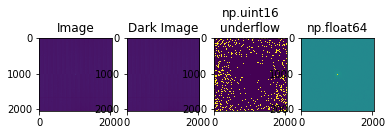

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=4)
axs[0].imshow(image)
axs[0].set_title("Image")
axs[1].imshow(dark_image)
axs[1].set_title("Dark Image")
axs[2].imshow(image - dark_image)
axs[2].set_title("np.uint16\nunderflow")
axs[3].imshow(image.astype(np.float64) - dark_image.astype(np.float64))
axs[3].set_title("np.float64")
plt.show()

In [8]:
def normalized_dark_subtracted_images(scan_ids):
    databroker = Broker.named("pdf")
    dark_subtracted_images = np.zeros((len(scan_ids), 2048*2048), dtype=np.float64)
    print(f"allocated {dark_subtracted_images.shape} image array")
    for i, scan_id in enumerate(scan_ids):
        image, dark_image = get_image_and_darkframe(scan_id)
        print(f"loaded image and dark image for scan id {scan_id}")
        dark_subtracted_images[i, :] = (image.astype(np.float64) - dark_image.astype(np.float64)).reshape(1, -1)
    
    t0 = time.time()
    normalized_dark_subtracted_images = dml_RobustScaler().fit_transform(da.from_array(dark_subtracted_images))
    t1 = time.time()
    print(f"dask_ml.preprocessing.robust_scale finished in {t1-t0:.3f}s")

    t0 = time.time()
    normalized_dark_subtracted_images = skl_robust_scale(dark_subtracted_images)
    t1 = time.time()
    print(f"sklearn.preprocessing.robust_scale finished in {t1-t0:.3f}s")
    
    return normalized_dark_subtracted_images

In [ ]:
t0 = time.time()
normalized_dark_subtracted_images([2069, 2069])
t1 = time.time()
print(f"{t1-t0}s")

allocated (2, 4194304) image array
image key: pe1c_image
image data type: uint16
dark image data type: uint16
loaded image and dark image for scan id 2069
image key: pe1c_image
image data type: uint16
dark image data type: uint16
loaded image and dark image for scan id 2069
